<h1>Imports</h1>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2

import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

<h1>Basic Visualization Checks</h1>
<p>Pull up a random image to make sure everything is appearing correctly.</p>

loading annotations into memory...
Done (t=6.03s)
creating index...
index created!


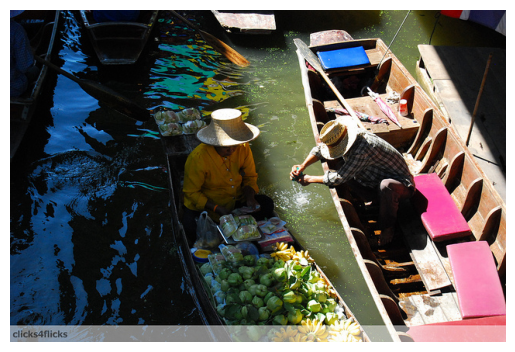

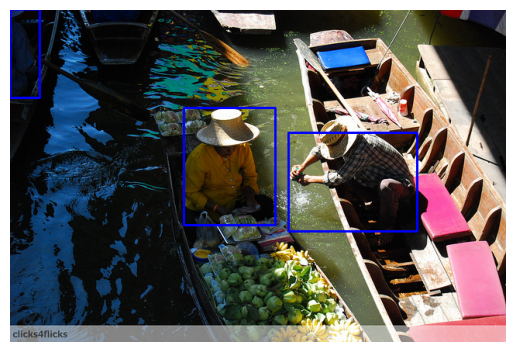

In [2]:
# Define the path to the COCO dataset
dataDir = './data'
dataType = 'train2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'

# Initialize the COCO API for instance annotations
coco = COCO(annFile)

# Get all category IDs
catIds = coco.getCatIds(catNms=['person'])

# Get all image IDs containing the specified category IDs
imgIds = coco.getImgIds(catIds=catIds)

# Load a random image
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

# Load and display the image
image_path = f"{dataDir}/{dataType}/{img['file_name']}"
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Load the annotations for the image
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

# Draw bounding boxes on the image
for ann in anns:
    bbox = ann['bbox']
    x, y, width, height = bbox
    cv2.rectangle(image, (int(x), int(y)), (int(x+width), int(y+height)), (255, 0, 0), 2)

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
# from pprint import pprint 
# for key in coco.anns.keys():
#     if coco.anns[key]['area'] <= 0:
#         print("FOUND BAD")
#         print(coco.anns[key])


FOUND BAD
{'segmentation': [[296.65, 388.33, 296.65, 388.33, 297.68, 388.33, 297.68, 388.33]], 'area': 0.0, 'iscrowd': 0, 'image_id': 200365, 'bbox': [296.65, 388.33, 1.03, 0.0], 'category_id': 58, 'id': 918}
FOUND BAD
{'segmentation': [[9.98, 188.56, 15.52, 188.56, 15.52, 188.56, 11.09, 188.56]], 'area': 0.0, 'iscrowd': 0, 'image_id': 550395, 'bbox': [9.98, 188.56, 5.54, 0.0], 'category_id': 1, 'id': 2206849}


<h1>Preprocess the Data</h1>


In [10]:
# Custom collate function to handle batches of images and targets
class PersonCocoDetection(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super().__init__(root, annFile, transform)
        self.coco = COCO(annFile)
        self.ids = self._filter_person_ids()

    def _filter_person_ids(self):
        person_ids = []
        person_category_id = self.coco.getCatIds(catNms=['person'])[0]
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=person_category_id, iscrowd=None)
            if len(ann_ids) > 0:
                person_ids.append(img_id)
        return person_ids
    
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        target = [ann for ann in target if ann['category_id'] == 1]
        return img, target


def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = []
    for item in batch:
        target = item[1]
        for ann in target:
            ann['bbox'] = torchvision.ops.box_convert(torch.tensor(ann['bbox']), 'xywh', 'xyxy').tolist()
        new_target = {
            'boxes': torch.tensor([ann['bbox'] for ann in target], dtype=torch.float32),
            'labels': torch.tensor([ann['category_id'] for ann in target], dtype=torch.int64),
            'image_id': torch.tensor([ann['image_id'] for ann in target], dtype=torch.int64),
            'area': torch.tensor([ann['area'] for ann in target], dtype=torch.float32),
            'iscrowd': torch.tensor([ann['iscrowd'] for ann in target], dtype=torch.int64)
        }
        targets.append(new_target)
    return images, targets


# Define transformation
transform = T.Compose([
    T.ToTensor()
])


dataDir = './data'
dataType = 'train2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'
dataset = PersonCocoDetection(root=f'{dataDir}/{dataType}', annFile=annFile, transform = transform)

train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=6.23s)
creating index...
index created!
loading annotations into memory...
Done (t=6.16s)
creating index...
index created!


<h1>Checking included Images<h1>

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from random import randint

# # Print out a random image to see if it is only including people
# selectedImage = randint(0, len(dataset))
# image, annotations = dataset[selectedImage]

# # Plot the image
# fig, ax = plt.subplots(1, figsize=(12, 9))
# ax.imshow(image.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C] for plotting

# # Plot the bounding boxes
# for ann in annotations:
#     bbox = ann['bbox']
#     x, y, width, height = bbox
#     rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     plt.text(x, y, f"Class: {ann['category_id']}", fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

# plt.axis('off')
# plt.show()

# # Print the annotations
# print("Annotations for the first image:")
# for ann in annotations:
#     print(ann)

# print('---------------------------')
# # Check that all included bounding boxes are valid
# checkedImages = 0
# for image in dataset:
#     for box in image[1]:
#         if box['area'] == 0:
#             print("BADBADBADBBAD")
#     checkedImages += 1
#     if checkedImages % 10000 == 0:
#         print(f"Checked {checkedImages} images so far.")


<h1>Model Selection</h1>

In [11]:
# Load a pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

# Get the number of input features
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head with a new one (only for person detection)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)  # 2 classes: person and background

# Training parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Optional scheduler

c:\Users\kanea\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<h1>Train Model</h1>

In [12]:
from tqdm import tqdm

# Training loop with progress bar
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for i, data in enumerate(train_dataloader):
            images, targets = data
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            if images is None or targets is None:
                print("FOUND NONE")
                continue

            optimizer.zero_grad()

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            losses.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix(loss=losses.item())

        lr_scheduler.step()  # Step the scheduler

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}")


Epoch 1/10:   0%|          | 0/4008 [00:00<?, ?it/s]